In [9]:
import os
import json
import numpy as np
from collections import Counter

# Load collected summary data
def load_summary_data(file_path):
    with open(file_path, "r") as f:
        return json.load(f)

# Compute descriptive statistics for chain lengths, impacts, and relevance
def compute_statistics(lengths, impacts, relevance):
    if not lengths:
        return {
            "mean_length": 0, "std_length": 0, "min_length": 0, "max_length": 0,
            "median_impact": 0, "min_impact": 0, "max_impact": 0,
            "mean_relevance": 0, "min_relevance": 0, "max_relevance": 0
        }

    return {
        "mean_length": np.mean(lengths),
        "std_length": np.std(lengths),
        "min_length": np.min(lengths),
        "max_length": np.max(lengths),
        "median_impact": np.median(impacts),
        "min_impact": np.min(impacts),
        "max_impact": np.max(impacts),
        "mean_relevance": np.mean(relevance),
        "min_relevance": np.min(relevance),
        "max_relevance": np.max(relevance),
    }

# Compute relevance fraction statistics
def compute_relevance_fraction_stats(all_chain_relevance_fraction):
    total_chains = len(all_chain_relevance_fraction)
    if total_chains == 0:
        return {
            "total_chains": 0,
            "mean_relevance_fraction": 0,
            "above_mean_count": 0,
            "above_mean_percentage": 0,
            "fully_relevant_count": 0,
            "fully_relevant_percentage": 0,
            "below_half_count": 0,
            "below_half_percentage": 0,
        }

    mean_relevance_fraction = np.mean(all_chain_relevance_fraction)
    
    above_mean_count = sum(1 for fraction in all_chain_relevance_fraction if fraction > mean_relevance_fraction)
    above_mean_percentage = (above_mean_count / total_chains) * 100

    fully_relevant_count = sum(1 for fraction in all_chain_relevance_fraction if fraction == 1.0)
    fully_relevant_percentage = (fully_relevant_count / total_chains) * 100

    below_half_count = sum(1 for fraction in all_chain_relevance_fraction if fraction < 0.5)
    below_half_percentage = (below_half_count / total_chains) * 100

    return {
        "total_chains": total_chains,
        "mean_relevance_fraction": mean_relevance_fraction,
        "above_mean_count": above_mean_count,
        "above_mean_percentage": above_mean_percentage,
        "fully_relevant_count": fully_relevant_count,
        "fully_relevant_percentage": fully_relevant_percentage,
        "below_half_count": below_half_count,
        "below_half_percentage": below_half_percentage,
    }

# Analyze chain data
def analyze_chains(data):
    total_chains = 0
    all_chain_lengths = []
    all_chain_impacts = []
    all_chain_relevance = []
    all_chain_relevance_fraction = []

    chains_ending_2023_2024 = Counter()
    chain_lengths_2023_2024 = []
    chain_impacts_2023_2024 = []
    chain_relevance_2023_2024 = []
    relevance_fraction_2023_2024 = []
    
    for chain in data:
        if chain['chain_label'] == 'valid':
            total_chains += 1
            content = chain["content"]
            content_length = len(content)
            cumulative_citation = sum(paper.get("citation_count", 0) for paper in content)
            relevance_score = sum(1 for paper in content if paper.get("relevance", 0) == 2)

            all_chain_lengths.append(content_length)
            all_chain_impacts.append(cumulative_citation)
            all_chain_relevance.append(relevance_score)

            # Chains ending in 2023/2024
            if content and content[-1].get("year") in {2023, 2024}:
                chains_ending_2023_2024[chain["chain_label"]] += 1
                chain_lengths_2023_2024.append(content_length)
                chain_impacts_2023_2024.append(cumulative_citation)
                chain_relevance_2023_2024.append(relevance_score)

    all_chain_relevance_fraction = [
            relevance / (length - 1) if length > 1 else 0
            for relevance, length in zip(all_chain_relevance, all_chain_lengths)]
        
    relevance_fraction_2023_2024 = [
        relevance / (length - 1) if length > 1 else 0
        for relevance, length in zip(chain_relevance_2023_2024, chain_lengths_2023_2024)
    ]  
    
    percent_2023_2024 = (len(chain_lengths_2023_2024) / total_chains) * 100 if total_chains > 0 else 0  
    
    # Compute overall statistics
    stats_all_chains = compute_statistics(all_chain_lengths, all_chain_impacts, all_chain_relevance)
    relevance_fraction_stats = compute_relevance_fraction_stats(all_chain_relevance_fraction)
    relevance_fraction_stats_2023_2024 = compute_relevance_fraction_stats(relevance_fraction_2023_2024)
    
    # Compute statistics for chains ending in 2023/2024
    stats_2023_2024 = compute_statistics(chain_lengths_2023_2024, chain_impacts_2023_2024, chain_relevance_2023_2024)

    return {
        "total_chains": total_chains,
        "stats_all_chains": stats_all_chains,
        "relevance_fraction_stats": relevance_fraction_stats,
        "relevance_fraction_stats_2023_2024": relevance_fraction_stats_2023_2024,
        "stats_2023_2024": stats_2023_2024,
        "chains_ending_2023_2024_by_label": dict(chains_ending_2023_2024),
        "percentages_2023_2024": percent_2023_2024
    }

# Main function to run the analysis
def main(summary_file_path):
    # Load data
    data = load_summary_data(summary_file_path)

    # Analyze data
    analysis_results = analyze_chains(data)

    # Print results
    print("### Analysis Results ###")
    print(f"Total Chains: {analysis_results['total_chains']}")
    print("\nStatistics for All Chains:")
    print(analysis_results["stats_all_chains"])
    print("\nRelevance Fraction Statistics:")
    print(analysis_results["relevance_fraction_stats"])
    print("\nStatistics for Chains Ending in 2023/2024:")
    print(analysis_results["stats_2023_2024"])
    print("\nRelevance Fraction Statistics 2023/2024:")
    print(analysis_results["relevance_fraction_stats_2023_2024"])
    print("\nChains Ending in 2023/2024 by Label:")
    print(analysis_results["chains_ending_2023_2024_by_label"])
    print("\n Percentages of Chains Ending in 2023/2024:")
    print(analysis_results["percentages_2023_2024"])


# Run the script
if __name__ == "__main__":
    summary_file_path = "./collected_chains_summary.json"  # Update with your file path
    main(summary_file_path)


### Analysis Results ###
Total Chains: 1184

Statistics for All Chains:
{'mean_length': 12.517736486486486, 'std_length': 4.622362974832371, 'min_length': 3, 'max_length': 27, 'median_impact': 1081.5, 'min_impact': 49, 'max_impact': 19220, 'mean_relevance': 6.556587837837838, 'min_relevance': 0, 'max_relevance': 21}

Relevance Fraction Statistics:
{'total_chains': 1184, 'mean_relevance_fraction': 0.5549866739282269, 'above_mean_count': 624, 'above_mean_percentage': 52.702702702702695, 'fully_relevant_count': 0, 'fully_relevant_percentage': 0.0, 'below_half_count': 378, 'below_half_percentage': 31.925675675675674}

Statistics for Chains Ending in 2023/2024:
{'mean_length': 13.339066339066338, 'std_length': 4.552238114988054, 'min_length': 4, 'max_length': 27, 'median_impact': 1178.0, 'min_impact': 55, 'max_impact': 19220, 'mean_relevance': 7.119164619164619, 'min_relevance': 1, 'max_relevance': 21}

Relevance Fraction Statistics 2023/2024:
{'total_chains': 814, 'mean_relevance_fraction'

In [3]:
from scipy.stats import pearsonr, spearmanr
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Load collected summary data
def load_summary_data(file_path):
    with open(file_path, "r") as f:
        return json.load(f)

# Compute descriptive statistics for chain lengths, impacts, and relevance
def compute_statistics(lengths, impacts, relevance):
    if not lengths:
        return {
            "mean_length": 0, "std_length": 0, "min_length": 0, "max_length": 0,
            "median_impact": 0, "min_impact": 0, "max_impact": 0,
            "mean_relevance": 0, "min_relevance": 0, "max_relevance": 0
        }

    return {
        "mean_length": np.mean(lengths),
        "std_length": np.std(lengths),
        "min_length": np.min(lengths),
        "max_length": np.max(lengths),
        "median_impact": np.median(impacts),
        "min_impact": np.min(impacts),
        "max_impact": np.max(impacts),
        "mean_relevance": np.mean(relevance),
        "min_relevance": np.min(relevance),
        "max_relevance": np.max(relevance),
    }

# Analyze chain data
def analyze_chains(data):
    total_chains = 0
    all_chain_lengths = []
    all_chain_impacts = []
    all_chain_relevance = []
    chain_lengths_2023_2024 = []
    chain_impacts_2023_2024 = []

    for chain in data:
        if chain['chain_label'] == 'valid':
            total_chains += 1
            content = chain["content"]
            content_length = len(content)
            cumulative_citation = sum(paper.get("citation_count", 0) for paper in content)
            relevance_score = sum(1 for paper in content if paper.get("relevance", 0) == 2)

            all_chain_lengths.append(content_length)
            all_chain_impacts.append(cumulative_citation)
            all_chain_relevance.append(relevance_score)

            # Chains ending in 2023/2024
            if content and content[-1].get("year") in {2023, 2024}:
                chain_lengths_2023_2024.append(content_length)
                chain_impacts_2023_2024.append(cumulative_citation)

    return {
        "total_chains": total_chains,
        "all_chain_lengths": all_chain_lengths,
        "all_chain_impacts": all_chain_impacts,
        "chain_lengths_2023_2024": chain_lengths_2023_2024,
        "chain_impacts_2023_2024": chain_impacts_2023_2024,
    }

# Compute correlation
def compute_correlation(lengths, impacts):
    if len(lengths) > 1 and len(impacts) > 1:
        pearson_corr, _ = pearsonr(lengths, impacts)
        spearman_corr, _ = spearmanr(lengths, impacts)
    else:
        pearson_corr, spearman_corr = 0, 0  # Not enough data
    return pearson_corr, spearman_corr

# Visualization function
def visualize_results(results):
    all_chain_lengths = results["all_chain_lengths"]
    all_chain_impacts = results["all_chain_impacts"]
    chain_lengths_2023_2024 = results["chain_lengths_2023_2024"]
    chain_impacts_2023_2024 = results["chain_impacts_2023_2024"]

    # Compute correlation
    pearson_corr_all, spearman_corr_all = compute_correlation(all_chain_lengths, all_chain_impacts)
    pearson_corr_2023_2024, spearman_corr_2023_2024 = compute_correlation(chain_lengths_2023_2024, chain_impacts_2023_2024)

    # Visualizations
    plt.figure(figsize=(6, 8))  # Compact size for double-column format

    color_all = "#E69F00"  # Orange
    color_2023_2024 = "#0072B2"  # Blue

    # Histogram of chain lengths (all chains)
    plt.subplot(2, 1, 1)  # Stack plots vertically
    plt.hist(all_chain_lengths, bins=10, edgecolor="black", alpha=0.7, color=color_all, label="All Chains")
    plt.hist(chain_lengths_2023_2024, bins=10, edgecolor="black", alpha=0.5, color=color_2023_2024, label="2023/2024 Chains")
    plt.xlabel("Chain Length")
    plt.ylabel("Frequency")
    plt.legend(fontsize=8)
    plt.title("Distribution of Chain Lengths", fontsize=10)

    # Scatter plot of chain length vs citation count
    plt.subplot(2, 1, 2)
    plt.scatter(all_chain_lengths, all_chain_impacts, alpha=0.7, label="All Chains", color=color_all)
    plt.scatter(chain_lengths_2023_2024, chain_impacts_2023_2024, alpha=0.7, label="2023/2024 Chains", color=color_2023_2024)
    plt.xlabel("Chain Length")
    plt.ylabel("Cumulative Citation Count")
    plt.legend(fontsize=8)
    plt.title("Chain Length vs Cumulative Citation Count", fontsize=10)

    # Add correlation stats to the plot
    plt.text(
        0.05, 0.85,
        f"All Chains:\nPearson: {pearson_corr_all:.2f}\nSpearman: {spearman_corr_all:.2f}",
        transform=plt.gca().transAxes,
        fontsize=8,
        bbox=dict(facecolor="white", alpha=0.5)
    )
    plt.text(
        0.05, 0.70,
        f"2023/2024 Chains:\nPearson: {pearson_corr_2023_2024:.2f}\nSpearman: {spearman_corr_2023_2024:.2f}",
        transform=plt.gca().transAxes,
        fontsize=8,
        bbox=dict(facecolor="white", alpha=0.5)
    )

    # Adjust layout for compactness
    plt.tight_layout()

    # Save as PDF
    plt.savefig("chain_analysis_with_correlation.pdf", format="pdf", dpi=300)
    plt.show()

# Main function to run the analysis
def main(summary_file_path):
    # Load data
    data = load_summary_data(summary_file_path)

    # Analyze data
    analysis_results = analyze_chains(data)
    print(analysis_results)
    # Visualize results
    #visualize_results(analysis_results)

# Run the script
if __name__ == "__main__":
    summary_file_path = "./collected_chains_summary.json"  # Update with your file path
    main(summary_file_path)


{'total_chains': 379, 'all_chain_lengths': [11, 6, 10, 13, 9, 10, 10, 4, 11, 6, 14, 25, 12, 17, 6, 11, 2, 8, 13, 7, 2, 8, 24, 10, 2, 7, 14, 9, 21, 16, 10, 16, 2, 6, 2, 14, 4, 7, 3, 1, 6, 19, 1, 3, 12, 17, 6, 8, 9, 9, 3, 8, 6, 12, 15, 9, 14, 6, 8, 7, 5, 4, 1, 2, 1, 8, 13, 7, 14, 7, 14, 1, 14, 1, 4, 2, 11, 3, 7, 13, 4, 8, 3, 4, 15, 8, 6, 14, 13, 8, 4, 11, 12, 8, 12, 1, 13, 5, 6, 10, 2, 8, 13, 13, 11, 11, 4, 14, 2, 13, 7, 6, 5, 15, 1, 9, 12, 4, 11, 8, 18, 9, 13, 6, 5, 14, 6, 10, 3, 9, 6, 11, 6, 5, 14, 15, 6, 11, 10, 10, 9, 8, 11, 9, 6, 9, 4, 10, 5, 10, 9, 10, 3, 5, 3, 2, 11, 9, 10, 6, 4, 8, 5, 10, 12, 9, 7, 10, 8, 7, 2, 2, 12, 10, 2, 8, 9, 8, 7, 8, 7, 5, 11, 6, 2, 10, 16, 4, 18, 4, 11, 4, 7, 6, 12, 20, 6, 9, 11, 12, 6, 14, 2, 6, 24, 17, 6, 11, 11, 6, 10, 13, 4, 16, 9, 9, 5, 2, 8, 6, 18, 12, 12, 10, 20, 6, 27, 19, 16, 11, 6, 16, 2, 9, 13, 13, 10, 13, 13, 15, 10, 4, 6, 18, 12, 15, 8, 17, 8, 2, 12, 8, 12, 7, 15, 14, 7, 11, 6, 17, 4, 4, 13, 5, 7, 15, 4, 20, 11, 9, 8, 17, 14, 8, 9, 5, 2, 18, 1

### Analysis Results ###
Total Chains: 379

Statistics for All Chains:
{'mean_length': 9.03957783641161, 'std_length': 4.7608801464653, 'min_length': 1, 'max_length': 27, 'median_impact': 680.0, 'min_impact': 0, 'max_impact': 19219, 'mean_relevance': 6.002638522427441, 'min_relevance': 0, 'max_relevance': 22}

Relevance Fraction Statistics:
{'total_chains': 379, 'mean_relevance_fraction': 0.7082328827268478, 'above_mean_count': 213, 'above_mean_percentage': 56.200527704485495, 'fully_relevant_count': 73, 'fully_relevant_percentage': 19.261213720316622, 'below_half_count': 49, 'below_half_percentage': 12.928759894459102}

Statistics for Chains Ending in 2023/2024:
{'mean_length': 10.945273631840797, 'std_length': 4.392665760937732, 'min_length': 2, 'max_length': 27, 'median_impact': 869.0, 'min_impact': 13, 'max_impact': 19219, 'mean_relevance': 7.582089552238806, 'min_relevance': 0, 'max_relevance': 22}

Relevance Fraction Statistics 2023/2024:
{'total_chains': 201, 'mean_relevance_fraction': 0.7410666142088783, 'above_mean_count': 106, 'above_mean_percentage': 52.736318407960205, 'fully_relevant_count': 30, 'fully_relevant_percentage': 14.925373134328357, 'below_half_count': 16, 'below_half_percentage': 7.960199004975125}

Chains Ending in 2023/2024 by Label:
{'valid': 201}

 Percentages of Chains Ending in 2023/2024:
53.03430079155673


In [12]:
import os
import json
import numpy as np
from collections import Counter, defaultdict

# Load collected summary data
def load_summary_data(file_path):
    with open(file_path, "r") as f:
        return json.load(f)

# Compute descriptive statistics for chain lengths, impacts, and relevance
def compute_statistics(lengths, impacts, relevance):
    if not lengths:
        return {
            "mean_length": 0, "std_length": 0, "min_length": 0, "max_length": 0,
            "median_impact": 0, "min_impact": 0, "max_impact": 0,
            "mean_relevance": 0, "min_relevance": 0, "max_relevance": 0
        }

    return {
        "mean_length": np.mean(lengths),
        "std_length": np.std(lengths),
        "min_length": np.min(lengths),
        "max_length": np.max(lengths),
        "median_impact": np.median(impacts),
        "min_impact": np.min(impacts),
        "max_impact": np.max(impacts),
        "mean_relevance": np.mean(relevance),
        "min_relevance": np.min(relevance),
        "max_relevance": np.max(relevance),
    }

# Compute relevance fraction statistics
def compute_relevance_fraction_stats(all_chain_relevance_fraction):
    total_chains = len(all_chain_relevance_fraction)
    if total_chains == 0:
        return {
            "total_chains": 0,
            "mean_relevance_fraction": 0,
            "above_mean_count": 0,
            "above_mean_percentage": 0,
            "fully_relevant_count": 0,
            "fully_relevant_percentage": 0,
            "below_half_count": 0,
            "below_half_percentage": 0,
        }

    mean_relevance_fraction = np.mean(all_chain_relevance_fraction)
    
    above_mean_count = sum(1 for fraction in all_chain_relevance_fraction if fraction > mean_relevance_fraction)
    above_mean_percentage = (above_mean_count / total_chains) * 100

    fully_relevant_count = sum(1 for fraction in all_chain_relevance_fraction if fraction == 1.0)
    fully_relevant_percentage = (fully_relevant_count / total_chains) * 100

    below_half_count = sum(1 for fraction in all_chain_relevance_fraction if fraction < 0.5)
    below_half_percentage = (below_half_count / total_chains) * 100

    return {
        "total_chains": total_chains,
        "mean_relevance_fraction": mean_relevance_fraction,
        "above_mean_count": above_mean_count,
        "above_mean_percentage": above_mean_percentage,
        "fully_relevant_count": fully_relevant_count,
        "fully_relevant_percentage": fully_relevant_percentage,
        "below_half_count": below_half_count,
        "below_half_percentage": below_half_percentage,
    }

# Analyze chain data
def analyze_chains(data):
    total_chains = 0
    all_chain_lengths = []
    all_chain_impacts = []
    all_chain_relevance = []
    all_chain_relevance_fraction = []

    chains_ending_2023_2024 = Counter()
    chain_lengths_2023_2024 = []
    chain_impacts_2023_2024 = []
    chain_relevance_2023_2024 = []
    relevance_fraction_2023_2024 = []
    
    # Replacement statistics
    replacement_stats = defaultdict(lambda: {"lengths": [], "score_2_fractions": []})

    for chain in data:
        if chain['chain_label'] == 'invalid_type1':
            total_chains += 1
            content = chain["content"]
            content_length = len(content)
            cumulative_citation = sum(paper.get("citation_count", 0) for paper in content)
            relevance_score = sum(1 for paper in content if paper.get("relevance", 0) == 2)

            all_chain_lengths.append(content_length)
            all_chain_impacts.append(cumulative_citation)
            all_chain_relevance.append(relevance_score)

            # Chains ending in 2023/2024
            if content and content[-1].get("year") in {2023, 2024}:
                chains_ending_2023_2024[chain["chain_label"]] += 1
                chain_lengths_2023_2024.append(content_length)
                chain_impacts_2023_2024.append(cumulative_citation)
                chain_relevance_2023_2024.append(relevance_score)

            # Calculate replacement percentage from filename
            filename = chain["file_name"]
            num_replacements = int(filename.split("_")[-2].split("_")[0])  # Extract replacements
            replacement_percentage = (num_replacements / content_length) * 100

            # Assign to replacement bucket
            if replacement_percentage <= 10:
                bucket = "10%"
            elif replacement_percentage <= 20:
                bucket = "20%"
            elif replacement_percentage <= 30:
                bucket = "30%"
            elif replacement_percentage <= 40:
                bucket = "40%"
            elif replacement_percentage <= 50:
                bucket = "50%"
            else:
                bucket = ">50%"

            # Calculate score 2 fraction and store
            score_2_fraction = relevance_score / content_length
            replacement_stats[bucket]["lengths"].append(content_length)
            replacement_stats[bucket]["score_2_fractions"].append(score_2_fraction)

    all_chain_relevance_fraction = [
        relevance / (length - 1) if length > 1 else 0
        for relevance, length in zip(all_chain_relevance, all_chain_lengths)
    ]
    relevance_fraction_2023_2024 = [
        relevance / (length - 1) if length > 1 else 0
        for relevance, length in zip(chain_relevance_2023_2024, chain_lengths_2023_2024)
    ]  
    
    percent_2023_2024 = (len(chain_lengths_2023_2024) / total_chains) * 100 if total_chains > 0 else 0  
    
    # Compute overall statistics
    stats_all_chains = compute_statistics(all_chain_lengths, all_chain_impacts, all_chain_relevance)
    relevance_fraction_stats = compute_relevance_fraction_stats(all_chain_relevance_fraction)
    relevance_fraction_stats_2023_2024 = compute_relevance_fraction_stats(relevance_fraction_2023_2024)
    
    # Compute statistics for chains ending in 2023/2024
    stats_2023_2024 = compute_statistics(chain_lengths_2023_2024, chain_impacts_2023_2024, chain_relevance_2023_2024)

    return {
        "total_chains": total_chains,
        "stats_all_chains": stats_all_chains,
        "relevance_fraction_stats": relevance_fraction_stats,
        "relevance_fraction_stats_2023_2024": relevance_fraction_stats_2023_2024,
        "stats_2023_2024": stats_2023_2024,
        "chains_ending_2023_2024_by_label": dict(chains_ending_2023_2024),
        "percentages_2023_2024": percent_2023_2024,
        "replacement_stats": replacement_stats
    }

# Main function to run the analysis
def main(summary_file_path):
    # Load data
    data = load_summary_data(summary_file_path)

    # Analyze data
    analysis_results = analyze_chains(data)

    # Print results
    print("### Analysis Results ###")
    print(f"Total Chains: {analysis_results['total_chains']}")
    print("\nStatistics for All Chains:")
    print(analysis_results["stats_all_chains"])
    print("\nRelevance Fraction Statistics:")
    print(analysis_results["relevance_fraction_stats"])
    print("\nStatistics for Chains Ending in 2023/2024:")
    print(analysis_results["stats_2023_2024"])
    print("\nRelevance Fraction Statistics 2023/2024:")
    print(analysis_results["relevance_fraction_stats_2023_2024"])
    print("\nChains Ending in 2023/2024 by Label:")
    print(analysis_results["chains_ending_2023_2024_by_label"])
    print("\n Percentages of Chains Ending in 2023/2024:")
    print(analysis_results["percentages_2023_2024"])

    print("\nReplacement Percentage Statistics:")
    for bucket, stats in analysis_results["replacement_stats"].items():
        if stats["lengths"]:
            total_chains = len(stats["lengths"])    
            mean_length = sum(stats["lengths"]) / len(stats["lengths"])
            min_length = min(stats["lengths"])
            max_length = max(stats["lengths"])
            mean_score_2_fraction = sum(stats["score_2_fractions"]) / len(stats["score_2_fractions"])
            print(f"{bucket}: Total= {total_chains}  Mean Length = {mean_length:.2f} ({min_length}, {max_length}), "
                  f"Score 2 Fraction = {mean_score_2_fraction:.2f}")
        else:
            print(f"{bucket}: No data")

# Run the script
if __name__ == "__main__":
    summary_file_path = "./collected_chains_summary.json"  # Update with your file path
    main(summary_file_path)


### Analysis Results ###
Total Chains: 1184

Statistics for All Chains:
{'mean_length': 12.517736486486486, 'std_length': 4.622362974832371, 'min_length': 3, 'max_length': 27, 'median_impact': 1081.5, 'min_impact': 49, 'max_impact': 19220, 'mean_relevance': 6.556587837837838, 'min_relevance': 0, 'max_relevance': 21}

Relevance Fraction Statistics:
{'total_chains': 1184, 'mean_relevance_fraction': 0.5549866739282269, 'above_mean_count': 624, 'above_mean_percentage': 52.702702702702695, 'fully_relevant_count': 0, 'fully_relevant_percentage': 0.0, 'below_half_count': 378, 'below_half_percentage': 31.925675675675674}

Statistics for Chains Ending in 2023/2024:
{'mean_length': 13.339066339066338, 'std_length': 4.552238114988054, 'min_length': 4, 'max_length': 27, 'median_impact': 1178.0, 'min_impact': 55, 'max_impact': 19220, 'mean_relevance': 7.119164619164619, 'min_relevance': 1, 'max_relevance': 21}

Relevance Fraction Statistics 2023/2024:
{'total_chains': 814, 'mean_relevance_fraction'

### Analysis Results ###
Total Chains: 1184

Statistics for All Chains:
{'mean_length': 12.517736486486486, 'std_length': 4.622362974832371, 'min_length': 3, 'max_length': 27, 'median_impact': 1081.5, 'min_impact': 49, 'max_impact': 19220, 'mean_relevance': 6.556587837837838, 'min_relevance': 0, 'max_relevance': 21}

Relevance Fraction Statistics:
{'total_chains': 1184, 'mean_relevance_fraction': 0.5549866739282269, 'above_mean_count': 624, 'above_mean_percentage': 52.702702702702695, 'fully_relevant_count': 0, 'fully_relevant_percentage': 0.0, 'below_half_count': 378, 'below_half_percentage': 31.925675675675674}

Statistics for Chains Ending in 2023/2024:
{'mean_length': 13.339066339066338, 'std_length': 4.552238114988054, 'min_length': 4, 'max_length': 27, 'median_impact': 1178.0, 'min_impact': 55, 'max_impact': 19220, 'mean_relevance': 7.119164619164619, 'min_relevance': 1, 'max_relevance': 21}

Relevance Fraction Statistics 2023/2024:
{'total_chains': 814, 'mean_relevance_fraction': 0.5666275217524009, 'above_mean_count': 408, 'above_mean_percentage': 50.122850122850124, 'fully_relevant_count': 0, 'fully_relevant_percentage': 0.0, 'below_half_count': 245, 'below_half_percentage': 30.0982800982801}

Chains Ending in 2023/2024 by Label:
{'invalid_type1': 814}

 Percentages of Chains Ending in 2023/2024:
68.75


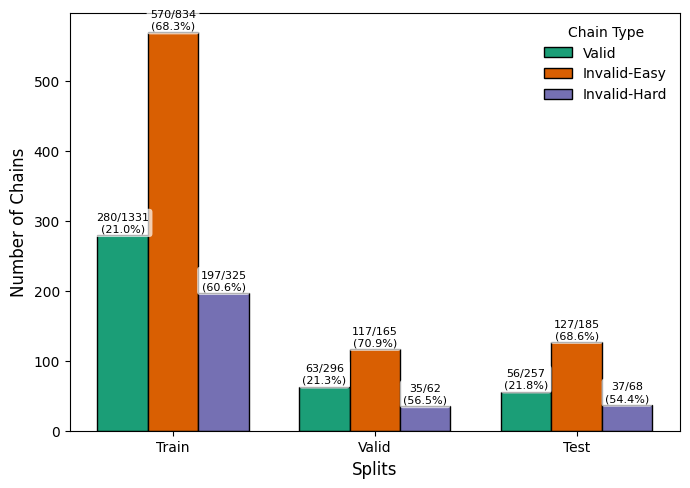

In [1]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np

# Paths to JSON files for train, valid, and test splits
splits_directory = "./balanced_splits/"
split_files = {
    "Train": os.path.join(splits_directory, "train.json"),
    "Valid": os.path.join(splits_directory, "valid.json"),
    "Test": os.path.join(splits_directory, "test.json"),
}

# Function to load and analyze data for each split
def load_split_data(file_path):
    with open(file_path, "r") as f:
        data = json.load(f)
    
    valid_chains = [chain for chain in data if chain["chain_label"] == "valid"]
    easy_chains = [chain for chain in data if chain["chain_label"] == "invalid_type1"]
    hard_chains = [chain for chain in data if chain["chain_label"] == "invalid_type2"]
    
    def count_2023_2024(chains):
        return sum(1 for chain in chains if chain["content"][-1]["year"] in {2023, 2024})
    
    return {
        "valid": {
            "total": len(valid_chains),
            "2023_2024": count_2023_2024(valid_chains),
        },
        "easy": {
            "total": len(easy_chains),
            "2023_2024": count_2023_2024(easy_chains),
        },
        "hard": {
            "total": len(hard_chains),
            "2023_2024": count_2023_2024(hard_chains),
        },
    }

# Load data for each split
results = {split: load_split_data(file_path) for split, file_path in split_files.items()}

# Extract data for the chart
splits = ["Train", "Valid", "Test"]

valid_total = [results[split]["valid"]["total"] for split in splits]
valid_2023_2024 = [results[split]["valid"]["2023_2024"] for split in splits]

easy_total = [results[split]["easy"]["total"] for split in splits]
easy_2023_2024 = [results[split]["easy"]["2023_2024"] for split in splits]

hard_total = [results[split]["hard"]["total"] for split in splits]
hard_2023_2024 = [results[split]["hard"]["2023_2024"] for split in splits]

# Bar width and positions
bar_width = 0.25
x = np.arange(len(splits))

# Plot initialization
fig, ax = plt.subplots(figsize=(7, 5))

# Bars for valid chains
valid_bars = ax.bar(
    x - bar_width, valid_2023_2024, bar_width, label="Valid", color="#1b9e77", edgecolor="black"
)
# Bars for easy chains
easy_bars = ax.bar(
    x, easy_2023_2024, bar_width, label="Invalid-Easy", color="#d95f02", edgecolor="black"
)
# Bars for hard chains
hard_bars = ax.bar(
    x + bar_width, hard_2023_2024, bar_width, label="Invalid-Hard", color="#7570b3", edgecolor="black"
)

# Add annotations for each bar
def add_annotations(bars, counts, totals):
    for bar, count, total in zip(bars, counts, totals):
        height = bar.get_height()
        percentage = (count / total) * 100 if total > 0 else 0
        annotation = f"{count}/{total}\n({percentage:.1f}%)"
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + 2,  # Offset the text slightly above the bar
            annotation,
            ha="center",
            va="bottom",
            fontsize=8,
            bbox=dict(facecolor="white", alpha=0.7, edgecolor="none", boxstyle="round,pad=0.3"),
        )

# Add annotations
add_annotations(valid_bars, valid_2023_2024, valid_total)
add_annotations(easy_bars, easy_2023_2024, easy_total)
add_annotations(hard_bars, hard_2023_2024, hard_total)

# Labels and legend
ax.set_xlabel("Splits", fontsize=12)
ax.set_ylabel("Number of Chains", fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(splits, fontsize=10)
ax.legend(title="Chain Type", fontsize=10, loc="upper right", frameon=False)

# Adjust layout
plt.tight_layout()

# Save and show the plot
#plt.savefig("dataset_split.pdf", format="pdf", dpi=300)
plt.show()


In [2]:
import json

# Function to count chains with length greater than a given threshold
def count_chains(data, length_threshold):
    """
    Counts the number of chains with a length above the specified threshold.
    :param data: List of chains (each chain is a dictionary with a 'content' field).
    :param length_threshold: Minimum length to qualify.
    :return: Count of chains with length above the threshold.
    """
    return sum(1 for chain in data if len(chain["content"]) > length_threshold)

# Load datasets
with open("./balanced_splits/train.json", "r") as f:
    train_data = json.load(f)

with open("./balanced_splits/valid.json", "r") as f:
    valid_data = json.load(f)

with open("./balanced_splits/test.json", "r") as f:
    test_data = json.load(f)

# Define the length threshold
length_threshold = 6

# Calculate counts and percentages for train, valid, and test
for split_name, split_data in zip(["Train", "Valid", "Test"], [train_data, valid_data, test_data]):
    total_chains = len(split_data)
    long_chains_count = count_chains(split_data, length_threshold)
    percentage_long_chains = (long_chains_count / total_chains) * 100 if total_chains > 0 else 0

    print(f"{split_name} Dataset:")
    print(f"  Total Chains: {total_chains}")
    print(f"  Chains with length > {length_threshold}: {long_chains_count}")
    print(f"  Percentage of chains with length > {length_threshold}: {percentage_long_chains:.2f}%\n")


Train Dataset:
  Total Chains: 2490
  Chains with length > 6: 1183
  Percentage of chains with length > 6: 47.51%

Valid Dataset:
  Total Chains: 523
  Chains with length > 6: 230
  Percentage of chains with length > 6: 43.98%

Test Dataset:
  Total Chains: 510
  Chains with length > 6: 264
  Percentage of chains with length > 6: 51.76%



In [1]:
import os
# add gpu support
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"
from dotenv import load_dotenv
load_dotenv()
huggingface_token = os.getenv("HUGGINGFACE_TOKEN")
from huggingface_hub import login
login(token=huggingface_token)
import json
import sys
sys.path.append('/srv/scratch1/rosni/scigen/')
from ground_truth_path.utils import clean_gpt_output, evaluate_papers_with_llama, load_llama_model

# Load the Llama model
llama_pipeline = load_llama_model()

 
def parse_llama_output(response):
    llama_output = {}
    for item in response:
        if item['role'] == 'assistant':
            try:
                return clean_gpt_output(item['content'])
            except json.JSONDecodeError as e:
                print(f"Error parsing LLAMA output: {e}")
                print(f"Problematic LLAMA content: {item['content']}")
    return llama_output



The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /home/user/rosni/.cache/huggingface/token
Login successful


Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

In [6]:
def extract_hypothesis_with_llama(title, abstract, llama_pipeline):
    """
    Uses the Llama model to extract core hypothesis/hypotheses from a given title and abstract.
    :param title: The title of the paper.
    :param abstract: The abstract of the paper.
    :param llama_pipeline: The loaded Llama model instance.
    :return: A cleaned and extracted hypothesis string.
    """
    try:
        # Construct the input for Llama
        prompt = (
            f"Hypotheses are frequently the starting point when undertaking the empirical portion of the scientific process. They guide the types of data collected, analyses conducted, and inferences drawn. You are a scientist. YYour task is to extract all meaningful hypotheses from the abstract of a given paper. These hypotheses may be explicitly stated or implicit in the text. To help identify implicit hypotheses: (1) Hypotheses may involve relationships between variables (e.g., how an independent variable impacts a dependent variable). (2) Hypotheses may compare groups or treatments (e.g., comparing outcomes between two groups based on a specific variable). Given the following paper title and abstract, Output all hypotheses clearly and concisely as a plain list in JSON format. If multiple hypotheses are present, extract each hypothesis separately and include them all in the following format:\n\n"
            f"Title: {title}\n"
            f"Abstract: {abstract}\n\n"
            f"Output the hypothesis or list of hypotheses in JSON format.\n"
            f"```json\n"
            f"{{\n"
            f"  \"Target Hypotheses\": [\n"
            f"    \"Hypothesis 1\",\n"
            f"    \"Hypothesis 2\",\n"
            f"    ...\n"
            f"  ]\n"
            f"}}"
            f"```"
        )

        # Use the Llama model to evaluate
        response = evaluate_papers_with_llama(prompt, llama_pipeline)
        llama_output = parse_llama_output(response)
        
        # Clean the Llama output
        #hypothesis = clean_gpt_output(llama_output)
        return llama_output

    except Exception as e:
        print(f"Error extracting hypothesis: {e}")
        return "Error extracting hypothesis"


def process_chains_with_llama(chains, llama_pipeline):
    """
    Processes a list of chains, extracting hypotheses for each paper in the chain using Llama.
    :param chains: List of chain dictionaries.
    :param model: The loaded Llama model instance.
    :return: Updated chains with extracted target hypotheses.
    """
    for chain in chains:
        # Get the list of papers in the chain
        papers = chain.get("content", [])
        
        # Initialize target_hypotheses for the metadata
        chain["target_hypothesis"] = "NA"
        
        # Ensure there is at least one paper in the chain
        if papers:
            # Extract the final paper in the chain
            final_paper = papers[-1]  # Get the last paper in the list
            title = final_paper.get("title", "No Title")
            abstract = final_paper.get("abstract", "No Abstract")
            
            # Extract the hypothesis only for the final paper
            if abstract and abstract != "No Abstract":
                hypothesis = extract_hypothesis_with_llama(title, abstract, llama_pipeline)
    
                # Append extracted hypothesis to the chain metadata
                chain["target_hypothesis"] = hypothesis
        print(chain["target_hypothesis"])
        sys.exit()
    return chains

# Load the dataset
with open("./balanced_splits/test.json", "r") as f:
    data = json.load(f)

# Process the chains with the Llama model
data = process_chains_with_llama(data, llama_pipeline)

output_dir = "./balance_splits_w_hyp/test_hyp.json"
os.makedirs(output_dir, exist_ok=True)

# Save the updated dataset
with open(output_dir, "w") as f:
    json.dump(data, f, indent=2)

print("Processed chains and updated the dataset with target hypotheses.")


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


{'Target Hypotheses': ['There is an association between PEAR1 polymorphism and the pharmacodynamics of ticagrelor in healthy Chinese subjects.', 'The PEAR1 rs12041331 polymorphism affects the in vitro inhibition of platelet aggregation (IPA) after ticagrelor incubation with platelet rich plasma from healthy Chinese subjects.', 'Genetic polymorphisms in PEAR1 are associated with responsiveness to ticagrelor in healthy Chinese subjects.']}


SystemExit: 

In [ ]:
import json

# Load the processed dataset
output_file = "./balanced_splits_w_hyp/test_hyp.json"

with open(output_file, "r") as f:
    data = json.load(f)

# Check overall structure
print(f"Total records: {len(data)}")

# Count missing or empty hypotheses
missing_hypothesis_count = sum(
    1 for chain in data if not chain.get("target_hypothesis") or chain["target_hypothesis"] == "NA"
)
print(f"Missing hypotheses count: {missing_hypothesis_count}")

# Display a few examples
for i, chain in enumerate(data[:5]):  # Show first 5 samples
    print(f"\nExample {i+1}:")
    print(f"Title: {chain['content'][-1]['title'] if chain['content'] else 'No Title'}")
    print(f"Extracted Hypothesis: {chain.get('target_hypothesis', 'NA')}")



In [3]:
data[0]

{'file_name': 'temporal_chain_CD005158_p-1.json',
 'chain_label': 'valid',
 'chain_source': 'latest',
 'file_path': '../ground_truth_path/result_chains/temporal_chain_CD005158_p-1.json',
 'content': [{'paperId': '8e9360f62ea548189c4ec9407d8f38d41f58152d',
   'pmid': '16531616',
   'title': 'Clopidogrel and aspirin versus aspirin alone for the prevention of atherothrombotic events.',
   'abstract': 'BACKGROUND\nDual antiplatelet therapy with clopidogrel plus low-dose aspirin has not been studied in a broad population of patients at high risk for atherothrombotic events.\n\n\nMETHODS\nWe randomly assigned 15,603 patients with either clinically evident cardiovascular disease or multiple risk factors to receive clopidogrel (75 mg per day) plus low-dose aspirin (75 to 162 mg per day) or placebo plus low-dose aspirin and followed them for a median of 28 months. The primary efficacy end point was a composite of myocardial infarction, stroke, or death from cardiovascular causes.\n\n\nRESULTS\n

In [3]:
import json

# Load the processed dataset
output_file = "./balanced_splits_w_hyp/train_hyp.json"

with open(output_file, "r") as f:
    data = json.load(f)

# Count the number of papers from 2024
papers_2024_count = sum(
    1 for chain in data if any(
        entry.get("year") == 2024 for entry in chain.get("content", [])
    )
)

print(f"Number of papers from 2024: {papers_2024_count}")


Number of papers from 2024: 736
